## *Imports*

In [2]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

import keras # high level api to tensorflow (or theano, CNTK, etc.) and useful image preprocessing
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 3.3.0


Using TensorFlow backend.
/home/jasonchin/miniconda3/envs/cvtest/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Keras image data format: channels_last


## *Constants*

In [3]:
IMAGES_FOLDER = os.path.join('images') # images for visuals

MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt') # path to model training history

## *Tools*

### Displaying images

#### Fix colour channel ordering for plotting

Matplotlib and OpenCV order colour channels in image matricies slightly differently, RGB and BGR respectively. We need to reorder the colour channels if we want to plot OpenCV images with Matplotlib.

In [3]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

#### Jupyter Notebook image display

In [4]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [5]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")

### OpenCV

#### Take webcam shot

In [6]:
video = cv2.VideoCapture(0)

while True:
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    # Display result
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27:# escape pressed 
        break
    elif k == 115: # s pressed
        fname = input("File name")
        cv2.imwrite(os.path.join(IMAGES_FOLDER, '{}.jpg'.format(fname)), frame)
        
cv2.destroyAllWindows()
video.release()

#### Reading video from webcam

Create an instance of a video capture object. Read and display frame by frame in a while loop until escape is pressed.

In [7]:
video = cv2.VideoCapture(0)

while True:
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    # Display result
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

#### Clean windows and release video capture

This is useful for when a video capture loop errors out, but your webcam is still stuck capturing and windows are left open.

In [8]:
cv2.destroyAllWindows()
video.release()

#### Getting key presses

It's sometimes useful to get key presses to alter the algorithms being run, stat certain processes, run functions, etc.

The video window must be selected to register a key press. *k*, in this case, will equal 255 if nothing is pressed.

In [9]:
while True:
    # Placeholder frame to show window
    window = np.zeros((300,300))
    
    # Display result
    cv2.imshow("frame", window)
    
    k = cv2.waitKey(1) & 0xff
    if k != 255: # A key is pressed
        print(k)
        
    if k == 27:# escape pressed 
        break
        
cv2.destroyAllWindows()
video.release()

27


## *Computer Vision Concepts*

### What computers see

Computers 'look' at images as multidimensional arrays or matricies but they can also be treated like functions (ex. taking the derivative over an image's x-axis).

Below an image is loaded from the file system and loaded into memory. This matrix is 387 x 600 x 3 which represents the number of rows x number of columns x number of colour channels (RGB/BGR).

We can then plot that data to view the image.

Note: When images are loaded in OpenCV, they return BGR (blue, green, red) channels, where as matplotlib expects RGB (red, green, blue). Therefore, we need  to convert the loaded image matrix from BGR to RGB.

Image Shape:  (480, 852, 3) 


Image Matrix: 
 [[[26 33 51]
  [26 33 51]
  [26 33 51]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [26 33 51]
  [27 34 52]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [27 34 52]
  [27 34 52]
  ..., 
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ..., 
 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ..., 
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]] 


Image Plotted:


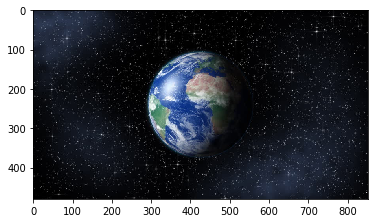

In [10]:
earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)
# comment out the line below to see the colour difference
earth_img = cv2.cvtColor(earth_img, cv2.COLOR_BGR2RGB)
plt.imshow(earth_img)

print('Image Shape: ', earth_img.shape, '\n\n')
print('Image Matrix: \n', earth_img, '\n\n')
print('Image Plotted:')

### Image Filters and Functions

Many times, images contain complex information that isn't need for a computation or reduces the speed of computation without much value added.

#### Blurring

Blurring is useful when there is noise in an image you want to remove.

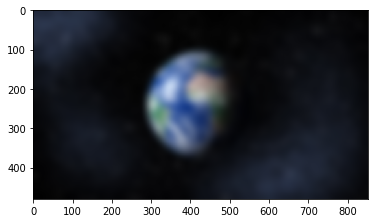

In [11]:
blur_img = earth_img.copy()
blur_img = cv2.GaussianBlur(blur_img, (41, 41), 10)
plt.imshow(blur_img)

#### Dilating

Dilation, as it sounds, dilates pixel neighbourhoods by finding maximums over the image by the kernel size given. This is useful for expanding selections (we'll look at this later).

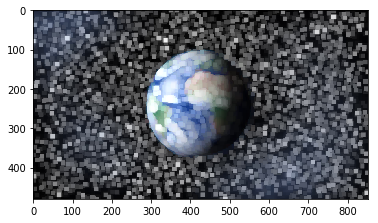

In [12]:
dilate_img = earth_img.copy()
dilate_img = cv2.dilate(dilate_img, np.ones((10,10), dtype=np.uint8), iterations=1)
plt.imshow(dilate_img)

#### Erosion

Erosion is the opposite of dilation, useful for remove noise.

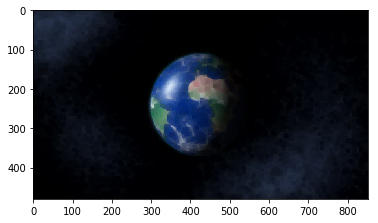

In [13]:
erosion_img = earth_img.copy()
erosion_img = cv2.erode(erosion_img, np.ones((10,10), dtype=np.uint8), iterations=1)
plt.imshow(erosion_img)

#### Canny edge detector

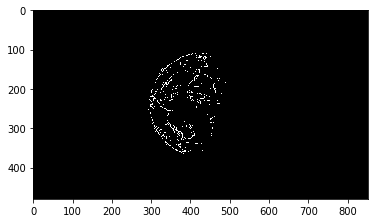

In [14]:
canny_img = earth_img.copy()
canny_img = cv2.erode(canny_img, np.ones((8,8), dtype=np.uint8), iterations=1)
edges = cv2.Canny(canny_img,100,100)
plt.imshow(edges.astype(np.uint8), cmap='gray')

#### Thresholding

Thresholding can be thought of as a function applied to each pixel of an image. This function takes a min and max thresholding values and if the pixel value falls in this range, it will 'return' the pixel, if not it will 'return' a black pixel.

Generally, thresholding is applied to a greyscale image, but may also be applied to colour images, following a similair principle.

(480, 852)


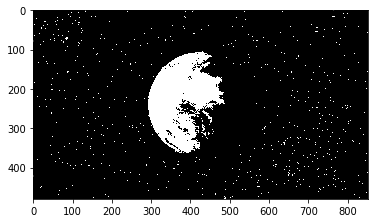

In [15]:
thresh_img = earth_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 80, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
print(thresh.shape)

### Background Subtraction Techniques

#### Using a background image to find differences (can be used for images and video)

This technique requires a background image to find the difference between the background and the current frame to find what as changed. This difference creates a 'mask' that represents where in the image the foreground is. A draw back of this algorithm is that any movement of the camera, change of lighting, change in focus, etc. will make the current frame totally different from the background image.

The algorithm:
* load in the background image and the current frame
* find the absolute difference between the images
* create a mask that contains a 'map' of pixels that should be 'on or off'
* apply the mask to the current frame to extract the foreground by iterating over each pixel and copying all pixels from the current frame that should be part of the foreground

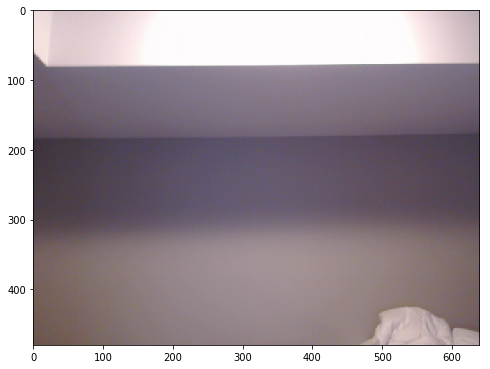

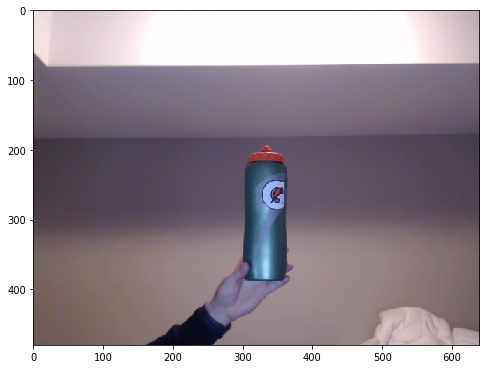

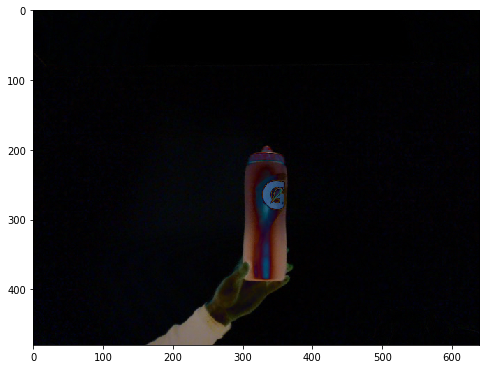

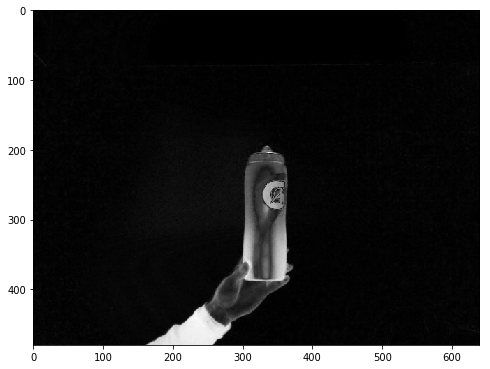

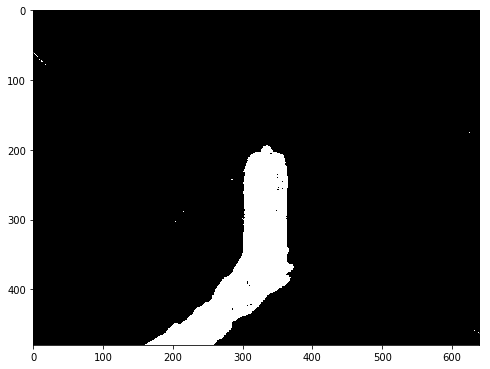

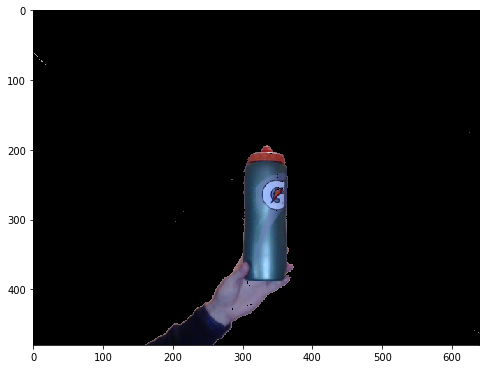

In [16]:
bg_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'bg.jpg'))
current_frame_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'current_frame.jpg'))

diff = cv2.absdiff(bg_img, current_frame_img)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
th, mask_thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

mask_indexes = mask_thresh > 0

foreground = np.zeros_like(current_frame_img, dtype=np.uint8)
for i, row in enumerate(mask_indexes):
    foreground[i, row] = current_frame_img[i, row]

plot_image(bg_img, recolour=True)
plot_image(current_frame_img, recolour=True)
plot_image(diff, recolour=True)
plot_image(mask)
plot_image(mask_thresh)
plot_image(foreground, recolour=True)

#### Using motion based background subtraction algorithms (mainly video)

These algorithms are most used for video. The algorithm looks at a series of frames and computes which pixels are most static and identifies the foreground by the pixels that are moving. The MOG2 and KNN background subtractors are two different algorithms.

In [17]:
ERODE = True

fgbg = cv2.createBackgroundSubtractorMOG2()
# fgbg = cv2.createBackgroundSubtractorKNN()

video = cv2.VideoCapture(os.path.join(IMAGES_FOLDER, 'bg_subtract_movement.mp4'))

while True:
    time.sleep(0.025)
    
    timer = cv2.getTickCount()
    
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    fgmask = fgbg.apply(frame)
    
    # Apply erosion to clean up noise
    if ERODE:
        fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(fgmask, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
 
    # Display result
    cv2.imshow("fgmask", fgmask)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

### Contours

Finding contours is done by finding points or corners in an image and connecting those that have the same color or intensity.

#### Finding contours and sorting contours

Here we sort the contours by area and get the 4 largest contours, but we can also find all contours that are greater than a certain size. We can also fill contours by passing -1 to the last parameter of cv2.drawContours().

You can also use contours for masking similair to how it was done above for background subtraction.

In [18]:
OUTLINE = True
LRG_ONLY = True

# window to hold the trackbar
img = np.zeros((300,512,3), np.uint8)
cv2.namedWindow('image')

# create trackbar
cv2.createTrackbar('Thresh', 'image', 0, 255, lambda x: None)

earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)

while True:
    thresh_min = cv2.getTrackbarPos('Thresh','image')
    
    contour_img = earth_img.copy()
    contour_img = cv2.cvtColor(contour_img, cv2.COLOR_BGR2GRAY)
    ret, contour_img_thresh = cv2.threshold(contour_img, thresh_min, 255, 0)
    im2, contours, hierarchy = cv2.findContours(contour_img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if LRG_ONLY:
        cnts = [x for x in contours if cv2.contourArea(x) > 20000]
    else:
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:3]

    if OUTLINE:
        # Draw only outlines
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), 2)
    else:
        # Draw filled contours
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), -1)

    contour_img_display = cv2.cvtColor(contour_img_display, cv2.COLOR_BGR2RGB)
    
    cv2.imshow('image', contour_img_display)
    cv2.imshow('thresh', contour_img_thresh)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        

cv2.destroyAllWindows()    
# plot_image(contour_img_thresh)
# plot_image(contour_img_display, recolour=True)

### Tracking

Tracking is a very complex topic and we will simply use OpenCV's tracking algorithms to track objects. For this tutorial, we will use the Kernelized Correlation Filters (KCF) tracking as it performs well and provides built in tracking error detection.

Available tracking algorithms:
* MIL
* BOOSTING
* MEDIANFLOW
* TLD
* KCF

In [19]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

video = cv2.VideoCapture(os.path.join(IMAGES_FOLDER, 'moving_subject_scale.mp4'))

# Read first frame
success, frame = video.read()
if not success:
    print("first frame not read")
    sys.exit()

tracker = setup_tracker(4)

# Select roi for bbox
bbox = cv2.selectROI(frame, False)
cv2.destroyAllWindows()

# Initialize tracker with first frame and bounding box
tracking_success = tracker.init(frame, bbox)

while True:
    time.sleep(0.02)
    
    timer = cv2.getTickCount()
    
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    # Update tracker
    tracking_success, bbox = tracker.update(frame)
    
    # Draw bounding box
    if tracking_success:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)        
    else:
        # Tracking failure
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)
    
    # Display result
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

###  (Deep) Neural Networks (NN/DNN)

To get a taste of neural networks, we're going to teach one how to add two numbers between 0 and 5000.

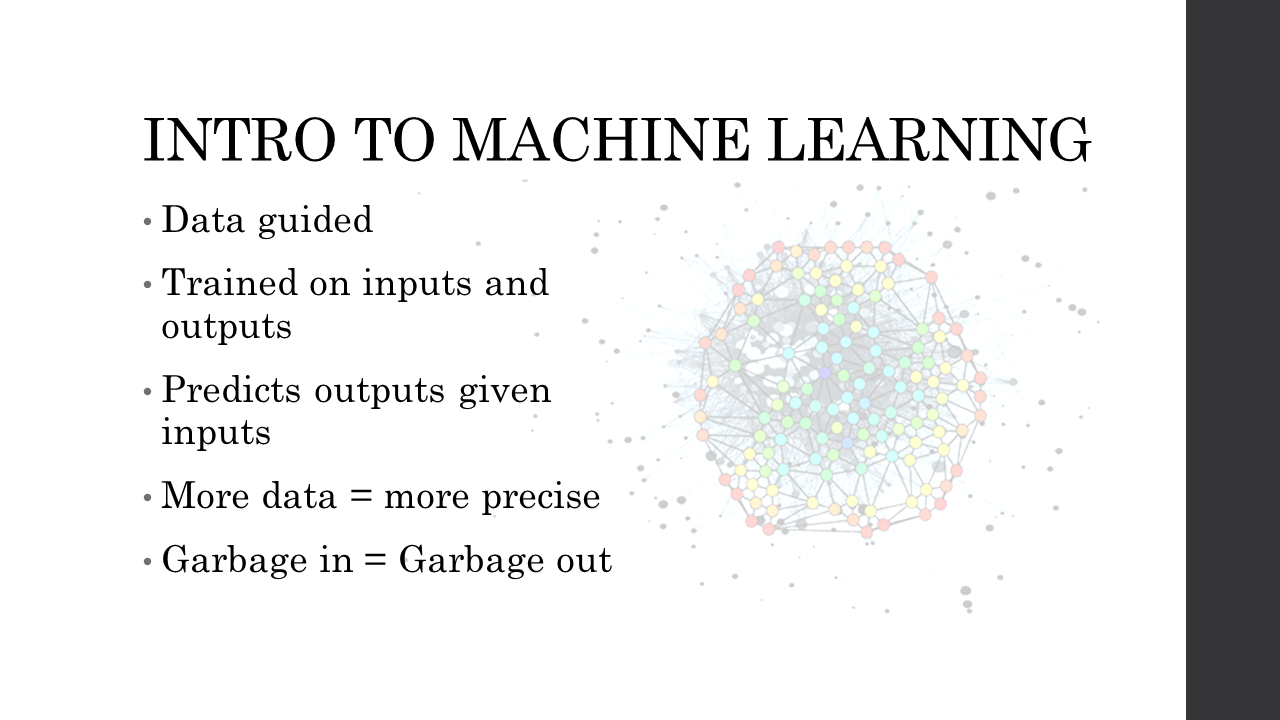

In [20]:
show_image(os.path.join('nnslides', 'slide8.png'))

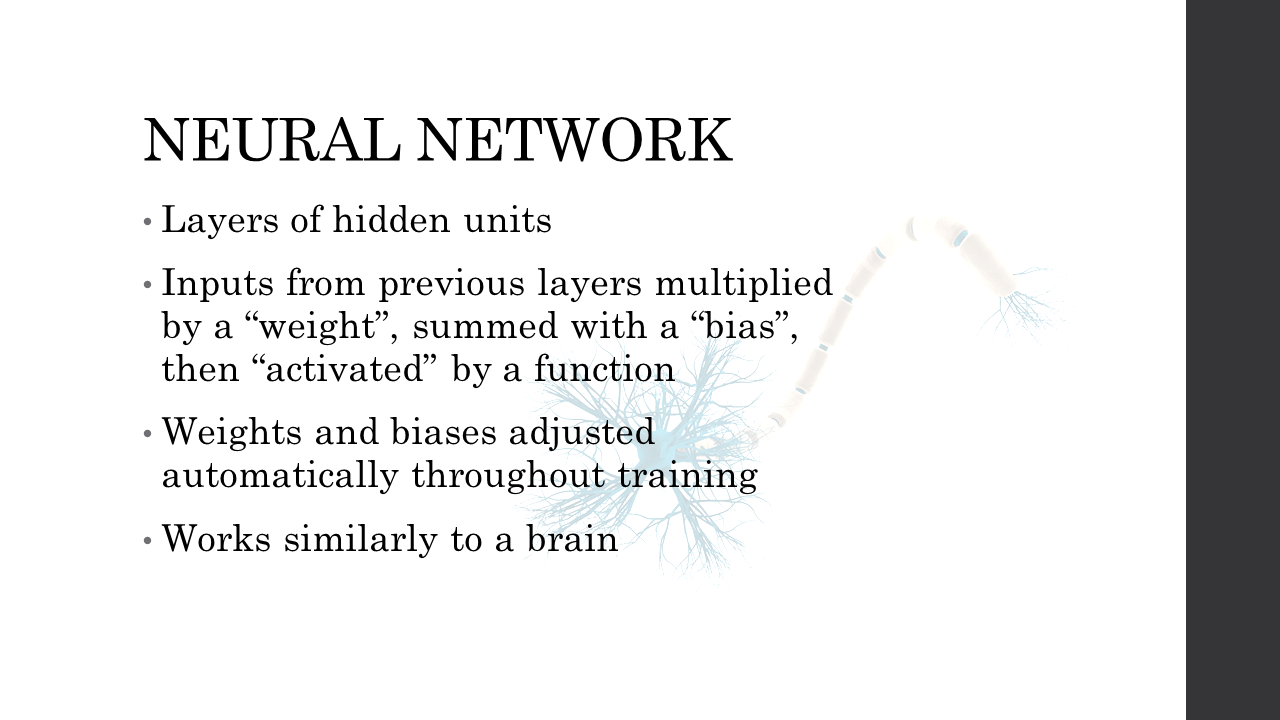

In [21]:
show_image(os.path.join('nnslides', 'slide11.png'))

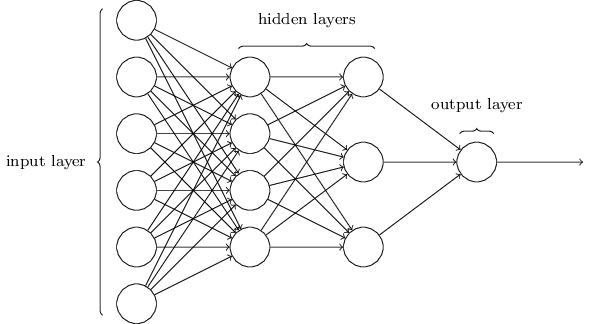

In [22]:
show_image("neuralnetwork.png")

Here we build our neural network and compile it with a loss function and optimizers of our choice.

In [23]:
test_model = Sequential()

test_model.add(Dense(2, input_shape=(2,), activation='relu'))
test_model.add(Dense(32, activation='relu'))
test_model.add(Dense(32, activation='relu'))
test_model.add(Dense(1, activation='relu'))

test_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

A nice look at the model's architecture.

In [24]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,191
Trainable params: 1,191
Non-trainable params: 0
_________________________________________________________________


Here we generate some data for the model to train on.

In [25]:
import random
# list of 5000 tuples, each with two numbers between 0 and 5000
data_x = [(random.randint(0, 5000), random.randint(0, 5000)) for x in range(5000)]
# list of the expected result when the two numbers are added
data_y = [x[0] + x[1] for x in data_x]

And now we train the model.

In [26]:
# test_model.fit(data_x, data_y, batch_size=16, epochs=2000, shuffle=True)

In [27]:
# test_model.save(os.path.join(MODEL_PATH, 'adder_model.hdf5'))

And now we have a (really bad) neural network calculator. What's really cool about this is that you can also add numbers the network has never seen before.

In [10]:
test_model = load_model(os.path.join(MODEL_PATH, 'adder_model.hdf5'), compile=False)
a = input("First number: ")
b = input("Second number: ")
d = np.expand_dims(np.array([a, b]), axis=0)
test_model.predict(d)

First number: 12000
Second number: 16000


array([[27999.951]], dtype=float32)

### (Deep) Convolutional Neural Networks (CNN/DCNN)

CNNs are a type of neural network often used for image problems. CNNs and DCNNs contain layers called convolutional layers that behave differently from the usual fully connected layers that you see in neural networks.

The images below come from https://brohrer.github.io/how_convolutional_neural_networks_work.html which offers a more in depth explanation.

"Regular" neural networks are less effective when working with images as every pixel is considered separately when calculating probabilities. This means that a normal fully-connected neural network is not good at classifying images, for example, if the object moves in the scene.

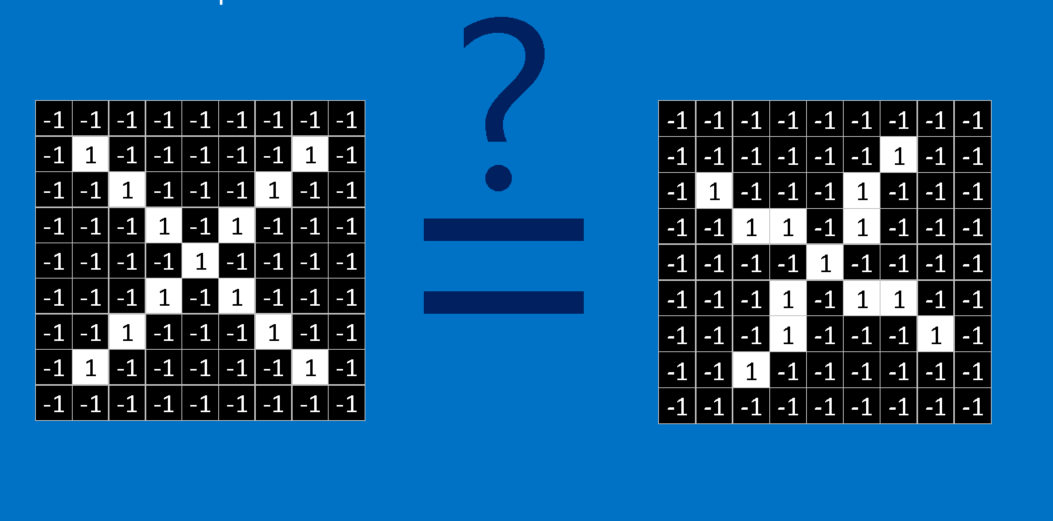

In [29]:
show_image('cnn1.png')

Convolutional layers learn to look for *features* that are found in an image of certain classes. This is useful because it means that early on in a computation the model is not looking for specific *things* but rather simpler features like edges and corners.

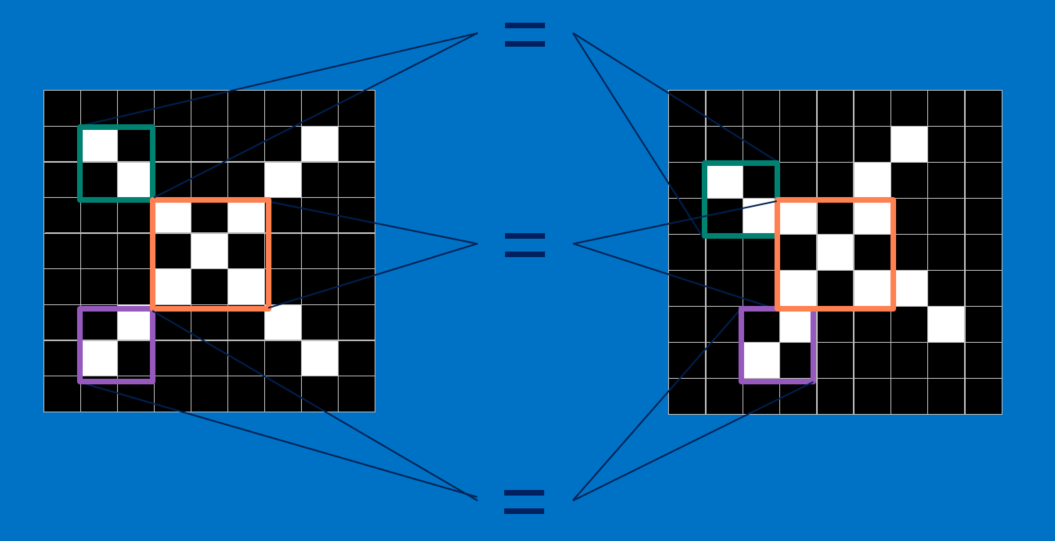

In [30]:
show_image('cnn2.png')

To look for these features, the convolutional layers learn *filters* that are applied accross the image using a sliding window. This window finds how similair the filter being applied and the region of the image is.

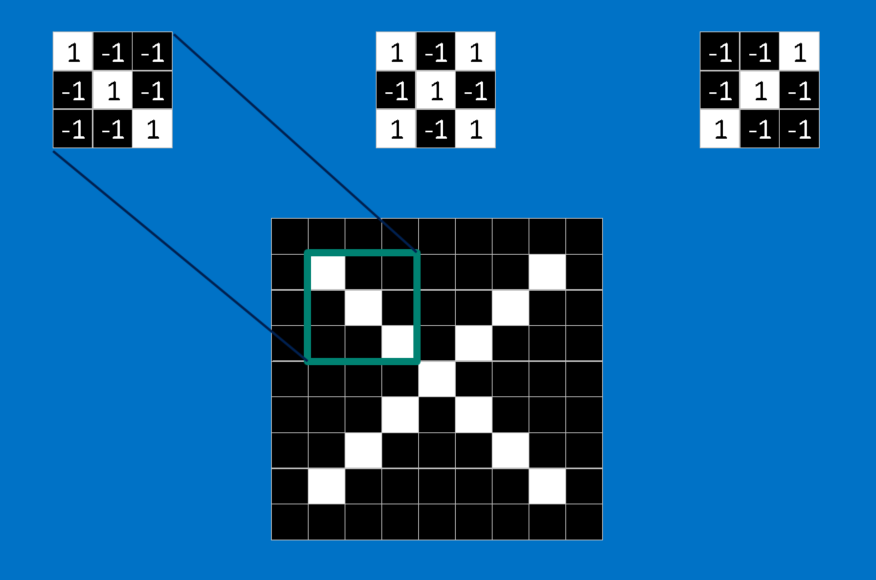

In [31]:
show_image('cnn3.png')

Early in the computation, the filters are looking for edges and corners, then evenutally uses these edges and corners to look for higher and higher level features. By the end of the computation, filters are being learned to look for very high level features.

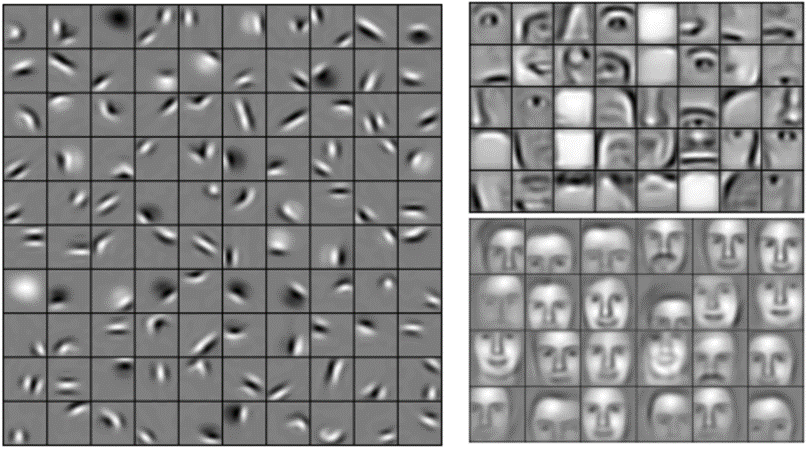

In [32]:
show_image('cnn4.png')

After features are extracted by the convolutional layers, this high level data is fed into a regular neural network which learns which features correspond to which outputs.

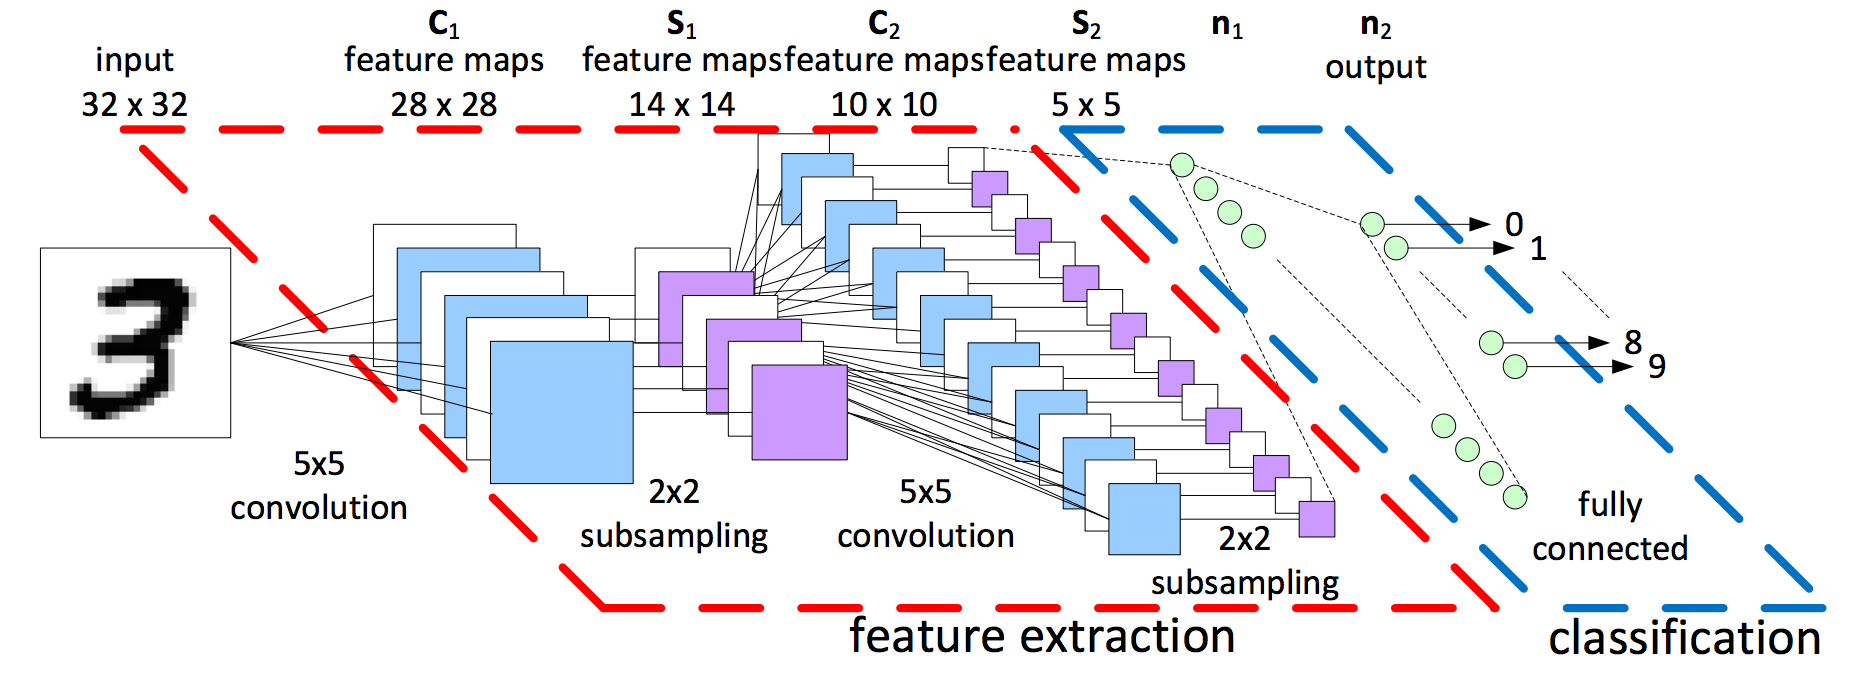

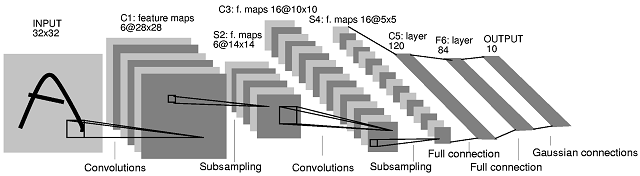

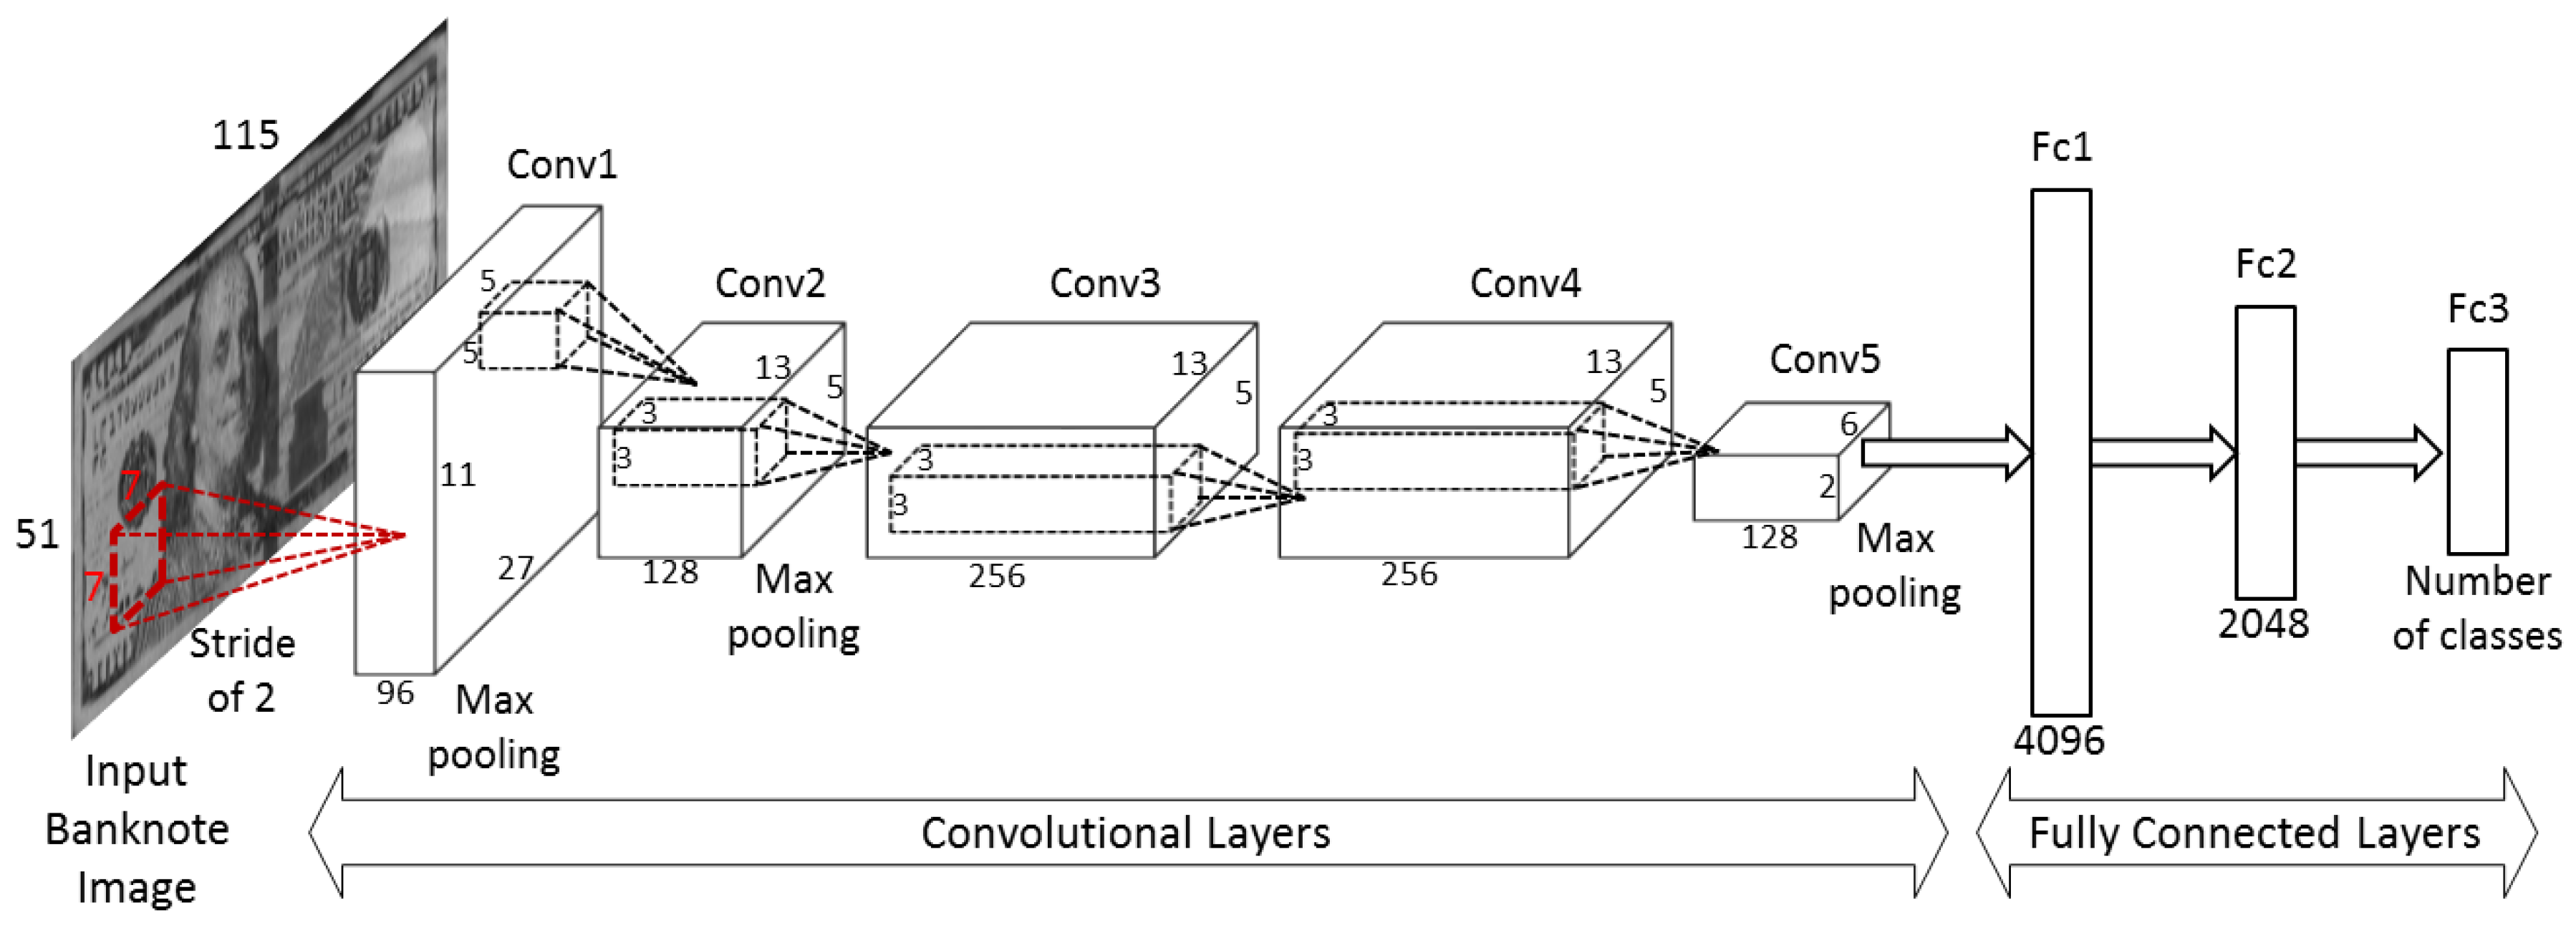

In [33]:
show_image('cnn5.png')
show_image('cnn6.png')
show_image('cnn7.png')

## *Demo: Gesture Recognition*
### Objective
Use computer vision to track the user's hand and recognize gestures.

### Extracting the subject
First we'll extract the user from the background to make tracking more effective and ensure a more accurate gesture prediction.

Here we take the first frame as the background frame (or reset the it by pressing 'r'). Then we use the frame difference method as previously described.

In [34]:
# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("frame", frame)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    # Display foreground
    cv2.imshow("foreground", foreground)
    
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [35]:
cv2.destroyAllWindows()
video.release()

### Tracking the hand
    
Display a bounding box and allow user to hit 't' to begin tracking.

In [36]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'fps': (15, 20)
}


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the hand
    hand_crop = frame[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

### Collecting data

The next objective is to recognize which gesture a hand is posed in. We will train our neural network on 4 gestures: fist, five, point and swing. For this network we will train the network on the mask to reduce dimensionality. Doing this makes it a more simple problem for the network to model, while sacrificing information stored in the colours of an image.

Here, we track our hand with the background subtracted and thresholded. Everytime you hit 's' a screen capture of your cropped hand is saved.

In [37]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

CURR_POSE = 'swing'
DATA = 'validation_data'

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}


# Image count for file name
img_count = 0

# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        img_count += 1
        fname = os.path.join(DATA, CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

### Building the Neural Network

Here we assemble the neural network with keras and compile it for training.

This is a very simple convolutional neural network containing three convolutional and max pooling layers. After a tensor is passed through the convolutional layers, it is flatted into a vector and passed through the dense layers.

In [38]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(54, 54, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Preparing Data for Training

Here we use the keras data generator to augment data. This loads data and applies certain transformations to it in order to improve generalization of the model.

The ImageDataGenerator.flow_from_directory() is a convenience method that prepares classification data according to file directories.

Training data is used to train the model to recognize gestures and validation data is used to verify that the model is not over fitting to the training data and the network is converging.

In [39]:
batch_size = 16

training_datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=10)

training_generator = training_datagen.flow_from_directory(
    'training_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    'validation_data',
    target_size=(54, 54),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 2047 images belonging to 4 classes.
Found 212 images belonging to 4 classes.


In [40]:
img = load_img('training_data/swing/swing_111.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in training_datagen.flow(x, batch_size=1,
                          save_to_dir='images/preview', save_prefix='fist', save_format='jpeg'):
    i += 1
    if i > 20:
        break

### Training the Network

Now we can train the model on the augmented data.

In [41]:
"""
model.fit_generator(
    generator=training_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=50,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=200 // batch_size,
    workers=8,
)
"""

'\nmodel.fit_generator(\n    generator=training_generator,\n    steps_per_epoch=2000 // batch_size,\n    epochs=50,\n    verbose=1,\n    validation_data=validation_generator,\n    validation_steps=200 // batch_size,\n    workers=8,\n)\n'

### Plotting Model History

Reading in the model fitting output and plotting the results.

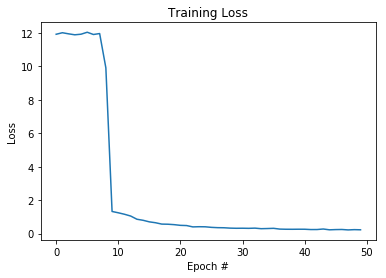

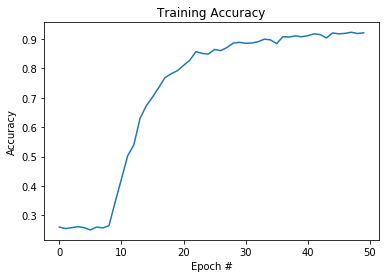

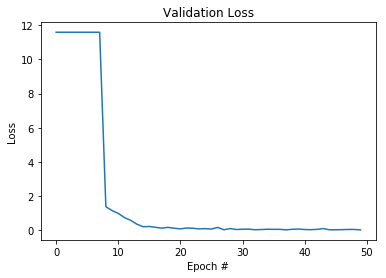

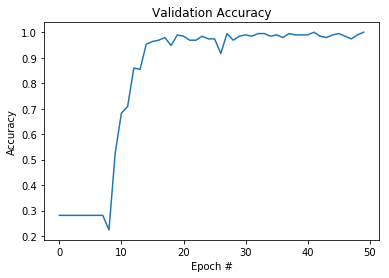

In [42]:
import re
with open(MODEL_HISTORY) as history_file:
    history = history_file.read()

data = {}

data['acc'] = re.findall(' acc: ([0-9]+\.[0-9]+)', history)
data['loss'] = re.findall(' loss: ([0-9]+\.[0-9]+)', history)
data['val_acc'] = re.findall(' val_acc: ([0-9]+\.[0-9]+)', history)
data['val_loss'] = re.findall(' val_loss: ([0-9]+\.[0-9]+)', history)

for key, values in data.items():
    for i, val in enumerate(values):
        values[i] = float(val)

plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['loss'])


plt.figure()
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['acc'])


plt.figure()
plt.title("Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.plot(data['val_loss'])


plt.figure()
plt.title("Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.plot(data['val_acc'])

In [43]:
# model.save("hand_model_gray.hdf5")

### Completed Demo

In [5]:
hand_model = load_model(MODEL_FILE, compile=False)

In [6]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if int(minor_ver) < 3:
        tracker = cv2.Tracker_create(tracker_type)
    else:
        if tracker_type == 'BOOSTING':
            tracker = cv2.TrackerBoosting_create()
        if tracker_type == 'MIL':
            tracker = cv2.TrackerMIL_create()
        if tracker_type == 'KCF':
            tracker = cv2.TrackerKCF_create()
        if tracker_type == 'TLD':
            tracker = cv2.TrackerTLD_create()
        if tracker_type == 'MEDIANFLOW':
            tracker = cv2.TrackerMedianFlow_create()
        if tracker_type == 'GOTURN':
            tracker = cv2.TrackerGOTURN_create()
    
    return tracker

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Display positions (pixel coordinates)
positions = {
    'hand_pose': (15, 40), # hand pose text
    'fps': (15, 20), # fps counter
    'null_pos': (200, 200) # used as null point for mouse control
}


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (116, 116, 170, 170) # Starting position for bounding box
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    data_display = np.zeros_like(display, dtype=np.uint8) # Black screen to display data
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    try:
        # Resize cropped hand and make prediction on gesture
        hand_crop_resized = np.expand_dims(cv2.resize(hand_crop, (54, 54)), axis=0).reshape((1, 54, 54, 1))
        prediction = hand_model.predict(hand_crop_resized)
        predi = prediction[0].argmax() # Get the index of the greatest confidence
        gesture = classes[predi]
        
        for i, pred in enumerate(prediction[0]):
            # Draw confidence bar for each gesture
            barx = positions['hand_pose'][0]
            bary = 60 + i*60
            bar_height = 20
            bar_length = int(400 * pred) + barx # calculate length of confidence bar
            
            # Make the most confidence prediction green
            if i == predi:
                colour = (0, 255, 0)
            else:
                colour = (0, 0, 255)
            
            cv2.putText(data_display, "{}: {}".format(classes[i], pred), (positions['hand_pose'][0], 30 + i*60), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)
            cv2.rectangle(data_display, (barx, bary), (bar_length, bary - bar_height), colour, -1, 1)
        
        cv2.putText(display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: {}".format(gesture), positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    except Exception as ex:
        cv2.putText(display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        cv2.putText(foreground_display, "hand pose: error", positions['hand_pose'], cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
    
    # Move the mouse
    hand_pos = ((p1[0] + p2[0])//2, (p1[1] + p2[1])//2)
    mouse_change = ((p1[0] + p2[0])//2 - positions['null_pos'][0], positions['null_pos'][0] - (p1[1] + p2[1])//2)
    # Draw mouse points
    cv2.circle(display, positions['null_pos'], 5, (0,0,255), -1)
    cv2.circle(display, hand_pos, 5, (0,255,0), -1)
    cv2.line(display,positions['null_pos'],hand_pos,(255,0,0),5)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display result
    cv2.imshow("data", data_display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 108: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        fname = os.path.join("data", CURR_POS, "{}_{}.jpg".format(CURR_POS, get_unique_name(os.path.join("data", CURR_POS))))
        cv2.imwrite(fname, hand_crop)
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()

In [46]:
cv2.destroyAllWindows()
video.release()

In [52]:
# Demo video for those who cannot run it
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/IJV11OGTNT8" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')